In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models




In [2]:

DATASET_PATH = r"C:\Users\naman\OneDrive\Desktop\deepglobe"
IMG_SIZE = (512, 512)

In [3]:
# RGB to Class Mapping
COLOR_MAP = {
    (0, 255, 255): 0,  # Urban land
    (255, 255, 0): 1,  # Agriculture land
    (255, 0, 255): 2,  # Rangeland
    (0, 255, 0): 3,    # Forest land
    (0, 0, 255): 4,    # Water
    (255, 255, 255): 5, # Barren land
    (0, 0, 0): 6       # Unknown
}

In [4]:
def rgb_to_class(mask):
    """Convert RGB mask to class labels."""
    class_mask = np.zeros(mask.shape[:2], dtype=np.uint8)  # Create empty class mask

    for rgb, class_index in COLOR_MAP.items():
        mask_indices = np.all(mask == rgb, axis=-1)  # Find pixels matching the RGB color
        class_mask[mask_indices] = class_index  # Assign class label
    
    return class_mask

In [5]:
def load_data(DATASET_PATH):
    images, masks = [], []

    # Get sorted file lists
    image_files = sorted([f for f in os.listdir(DATASET_PATH) if f.endswith("_sat.jpg")])
    mask_files = sorted([f for f in os.listdir(DATASET_PATH) if f.endswith("_mask.png")])

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(DATASET_PATH, img_file)
        mask_path = os.path.join(DATASET_PATH, mask_file)

        # Load and preprocess image
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = img / 255.0  # Normalize

        # Load and preprocess mask
        mask = cv2.imread(mask_path)  
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Convert to RGB
        mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
        mask = rgb_to_class(mask)  # Convert RGB mask to class index

        images.append(img)
        masks.append(mask)

    return np.array(images, dtype=np.float16), np.array(masks, dtype=np.uint8)

In [6]:
images, masks = load_data(DATASET_PATH)

# Print shape to verify
print("Images Shape:", images.shape)  # Expected: (num_images, 512, 512, 3)
print("Masks Shape:", masks.shape)   # Expected: (num_images, 512, 512)

Images Shape: (803, 512, 512, 3)
Masks Shape: (803, 512, 512)


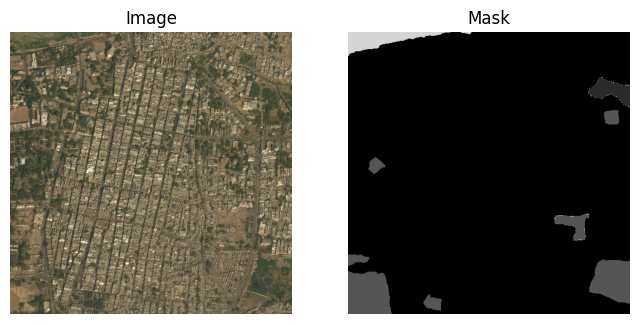

In [7]:
# Show first image
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(images[5].astype(np.float32))  # First image
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(masks[5], cmap="gray")  # First mask in grayscale
plt.title("Mask")
plt.axis("off")

plt.show()

In [8]:
# Print unique values in the mask
print("Unique classes in the mask:", np.unique(masks[5]))

Unique classes in the mask: [0 1 2 5 6]


In [9]:
def class_to_rgb(mask, color_map):
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    for rgb, class_idx in color_map.items():
        rgb_mask[mask == class_idx] = rgb  # Replace class indices with RGB colors

    return rgb_mask

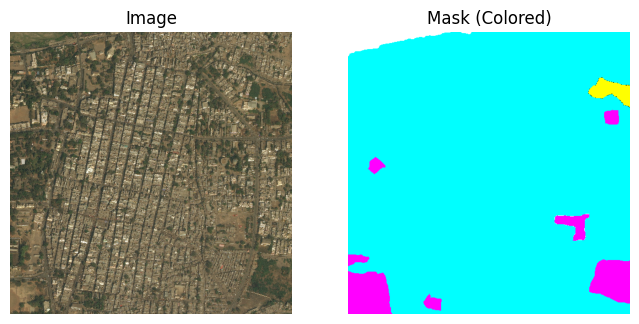

In [10]:
# Convert and visualize
rgb_mask = class_to_rgb(masks[5], COLOR_MAP)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(images[5].astype(np.float32))  # Show the image
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rgb_mask)  # Show the mask in correct colors
plt.title("Mask (Colored)")
plt.axis("off")

plt.show()

In [11]:
total_samples = len(images)
train_size = int(0.8 * total_samples)  # 80% for training
valid_size = total_samples - train_size  # 20% for validation
print(f"Total: {total_samples}, Training: {train_size}, Validation: {valid_size}")

Total: 803, Training: 642, Validation: 161


In [12]:
# Convert to NumPy arrays (if not already)
images = np.array(images)
masks = np.array(masks)

# Split dataset (stratify is not used since segmentation masks are pixel-wise)
X_train, X_valid, y_train, y_valid = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_valid.shape}, {y_valid.shape}")

Training set: (642, 512, 512, 3), (642, 512, 512)
Validation set: (161, 512, 512, 3), (161, 512, 512)


In [13]:
np.save("X_train_big.npy", X_train)
np.save("y_train_big.npy", y_train)
np.save("X_valid_big.npy", X_valid)
np.save("y_valid_big.npy", y_valid)

print("Datasets saved successfully!")

Datasets saved successfully!


In [ ]:
# X_train = np.load("X_train.npy")
# y_train = np.load("y_train.npy")
# X_valid = np.load("X_valid.npy")
# y_valid = np.load("y_valid.npy")

In [ ]:


def build_unet(input_shape=(512, 512, 3), num_classes=7):
    """Build U-Net model using MobileNetV2 as a feature extractor for DeepGlobe dataset."""
    inputs = layers.Input(shape=input_shape)

    # Load pre-trained MobileNetV2 as encoder
    base_model = tf.keras.applications.MobileNetV2(input_tensor=inputs, include_top=False, weights="imagenet")

    # Freeze the first few layers to retain pre-trained features
    for layer in base_model.layers[:50]:
        layer.trainable = False

    # Extract encoder layers for skip connections
    skip1 = base_model.get_layer("block_1_expand_relu").output  # 256x256
    skip2 = base_model.get_layer("block_3_expand_relu").output  # 128x128
    skip3 = base_model.get_layer("block_6_expand_relu").output  # 64x64
    skip4 = base_model.get_layer("block_13_expand_relu").output  # 32x32
    encoder_output = base_model.output  # 16x16 feature maps

    # Decoder (Bilinear Upsampling + Skip Connections)
    def upsample_block(x, skip, filters):
        x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)  # Bilinear Upsampling
        x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        x = layers.ReLU()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)  # Regularization
        x = layers.Concatenate()([x, skip])
        return x

    x = upsample_block(encoder_output, skip4, 256)  # 32x32
    x = upsample_block(x, skip3, 128)  # 64x64
    x = upsample_block(x, skip2, 64)   # 128x128
    x = upsample_block(x, skip1, 32)   # 256x256

    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)  # 512x512
    x = layers.Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)

    # Output Layer (Softmax for multi-class segmentation)
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
unet_model = build_unet()

In [ ]:
unet_model.summary()

In [ ]:
# Custom IoU Metric
class IoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes):
        super().__init__(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)  # Convert softmax output to class indices
        return super().update_state(y_true, y_pred, sample_weight)

# Compile Model
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR for better convergence
    loss="sparse_categorical_crossentropy",  # Suitable for integer-labeled masks
    metrics=["accuracy", IoU(num_classes=7)]  # DeepGlobe has 6 land cover classes
)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Track validation loss
    patience=5,  # Stop if val_loss doesn’t improve for 5 epochs
    restore_best_weights=True,  # Restore best model weights
    verbose=1
)

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,  # Reduce LR by half if no improvement
    patience=3,  # Wait 3 epochs before reducing LR
    min_lr=1e-6,  # Minimum LR to prevent model from stopping learning
    verbose=1
)

In [ ]:
print("Mask unique values:", np.unique(y_train))

In [ ]:
print("X_train shape:", X_train.shape)  # Should be (num_samples, 512, 512, 3)
print("y_train shape:", y_train.shape)

In [ ]:

history = unet_model.fit(
    X_train, y_train,  # Use only 10 training samples
    validation_data=(X_valid, y_valid),  # Use 10 validation samples
    batch_size=8,  # Small batch size to avoid memory issues
    epochs=30,  # Reduce epochs for quick testing
    verbose=1,  
    callbacks=[lr_scheduler, early_stopping],  # Include both callbacks
    shuffle=True  
)


In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(18, 5))  # Wider figure for better visualization

    # Plot Loss Curve
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    # Plot Accuracy Curve (If exists)
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 3, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy Curve')

    # Plot IoU Curve (If exists)
    if 'mean_io_u' in history.history and 'val_mean_io_u' in history.history:
        plt.subplot(1, 3, 3)
        plt.plot(history.history['mean_io_u'], label='Train IoU')
        plt.plot(history.history['val_mean_io_u'], label='Validation IoU')
        plt.xlabel('Epochs')
        plt.ylabel('IoU Score')
        plt.legend()
        plt.title('IoU Curve')

    plt.show()

# Call function
plot_training_history(history)
